# Voting change 2024 analysis

This is a quick notebook to examine the way the changes applied are affecting individual voting records.

The three changes are:

* Absences are now non-scoring
* Weak votes are now non-scoring
* A series of "non-action" votes have been downgraded to weak votes.

Explored a bit in the below is there are six policies entirely made up of non-action votes that will be removed. 

This analysis generally validates that there isn't a lot of big changes to the direction of top-line summaries as a result of this. This is good because we don't generally want these to be too sensitive to the exact formula used (and this is accomplished by the relatively big cut-off blocks for different text descriptions).

The most noticeable change will be a load of MPs no longer having relevant votes for a set of policies - either because we're removed them as entirely non-scoring (e.g. made entirely of opposition day votes), or where the effective range of a long-running policy has been trimmed.

82% of MP-Policy links are either the same, or have a stronger/weaker version of the same alignment (e.g. has not changed if the MP is for or against the policy). About 12-13% will no longer exist - with the remaining being previously middle-of-the-road assignments gaining a sign (or the reverse), and a small cohort where the direction of the MP-Policy link has changed (explored more below)

Generally, these are good changes that narrow the focus and make the process more explainable - but also the huge amount of MP-policy links with no big change reflect the following about how this was already working:

* Weak votes were so weak they effectively had little impact in most cases.
* Absences in the old system had a moderating effect on the overall score - removing this makes the results more extreme. 
* Most votes used to calculate policies were in some way "action" votes - with very few policies entirely made up of non-action votes, and many MP-Policy descriptions entirely unaffected by removing them all. 

The goal of this process is to simplify how we work, and how we explain how we work - but from an end-product point of view, this doesn't change a lot. It's a good progression and simplification rather than a revolution. 

As a result of this analysis I have made a small amend to the scoring process, where more than one "strong absence" will cap the maximum score at 0.15-0.85 - preventing policies with many absences being given a "consistently" description. 

In [1]:
from __future__ import annotations
import pandas as pd
from pathlib import Path
import ptitprince as ptp
import numpy as np


import requests

from typing import Type, Any

from voting_2024_change_analysis.scoring import (
    ScoreFloatPair,
    ScoringFuncProtocol,
    PublicWhipScore,
    SimplifiedScore,
    SimplifiedGradiatedScore,
)

In [2]:
def calculate_score(
    row: pd.Series[Any], scoring_func: Type[ScoringFuncProtocol]
) -> float:
    return scoring_func().score(
        votes_same=ScoreFloatPair(
            weak=row["num_votes_same"], strong=row["num_strong_votes_same"]
        ),
        votes_different=ScoreFloatPair(
            weak=row["num_votes_different"], strong=row["num_strong_votes_different"]
        ),
        votes_absent=ScoreFloatPair(
            weak=row["num_votes_absent"], strong=row["num_strong_votes_absent"]
        ),
        votes_abstain=ScoreFloatPair(
            weak=row["num_votes_abstained"], strong=row["num_strong_votes_abstained"]
        ),
        agreements_same=ScoreFloatPair(weak=0, strong=0),
        agreements_different=ScoreFloatPair(weak=0, strong=0),
    )

In [3]:
# combine into one dataframe with both sets of data

df_new = pd.read_parquet(Path("..", "data", "raw", "person_policies_new.parquet"))

df_new["pw_score"] = df_new.apply(
    lambda row: calculate_score(row, PublicWhipScore), axis=1
)
df_new["simple_with_grad_score"] = df_new.apply(
    lambda row: calculate_score(row, SimplifiedGradiatedScore), axis=1
)
df_new["simple_score"] = df_new.apply(
    lambda row: calculate_score(row, SimplifiedScore), axis=1
)

df_old = pd.read_parquet(Path("..", "data", "raw", "person_policies_original.parquet"))

df_old["pw_score"] = df_old.apply(
    lambda row: calculate_score(row, PublicWhipScore), axis=1
)
df_old["simple_with_grad_score"] = df_old.apply(
    lambda row: calculate_score(row, SimplifiedGradiatedScore), axis=1
)
df_old["simple_score"] = df_old.apply(
    lambda row: calculate_score(row, SimplifiedScore), axis=1
)

compare_cols = [
    "is_target",
    "policy_id",
    "person_id",
    "comparison_party",
    "chamber",
    "pw_score",
    "simple_with_grad_score",
    "simple_score",
]
join_on = ["is_target", "policy_id", "person_id", "chamber", "comparison_party"]

jf = df_new[compare_cols].merge(
    df_old[compare_cols], on=join_on, suffixes=("_new", "_old")
)

In [4]:
current_mps = pd.read_parquet(
    "https://pages.mysociety.org/politician_data/data/uk_politician_data/latest/simple_memberships.parquet"
)

current_mps["person_id"] = current_mps["person_id"].str.split("/").str[-1]

mask = current_mps["end_date"].isna() & (current_mps["chamber"] == "commons")

current_mps["name_with_id"] = (
    current_mps["nice_name"] + " (" + current_mps["person_id"] + ")"
)

person_name_map = current_mps.set_index("person_id")["name_with_id"].to_dict()

current_mps = current_mps[mask]

current_mp_ids = current_mps["person_id"].astype(int).tolist()

jf["is_current_mp"] = jf["person_id"].isin(current_mp_ids)
jf["person_name"] = jf["person_id"].astype(str).map(person_name_map)

In [5]:
# get the currently active policies

active_url = "https://twfy-votes.staging.mysociety.org/policies/commons/active/all.json"

r = requests.get(active_url)
data = r.json()

active_ids = {x["id"]: f'{x["name"]} ({x["id"]})' for x in data["policies"]}

# convert the dict into a dataframe with a policy_id and policy_name column

active_df = pd.DataFrame(active_ids.items(), columns=["policy_id", "policy_name"])

In [6]:
df = jf


# drop is_target = 1
df = df.drop(df[df["is_target"] == 0].index)

# limit to just active policies
df = df[df["policy_id"].isin(active_ids.keys())]

# drop policy_ids listed
dropped_policies = [6682, 6692, 6697, 6702, 6710, 6747]
# df = df.drop(df[df["policy_id"].isin(dropped_policies)].index)

# merge in name column
df = df.merge(active_df, on="policy_id")

# we want to see on the new scoring system, what the diff in scoring is for each policy
# so that's simple_score_new - simple_score_old

# first level
# from pw_score_old to simple_with_grad_score_old
df["change_absences_diff"] = (
    df["pw_score_old"] - df["simple_with_grad_score_old"]
).abs()

# second level
# from simple_with_grad_score_old to simple_score_old
df["change_weak_weight_diff"] = (
    df["simple_with_grad_score_old"] - df["simple_score_old"]
).abs()

df["rescore_votes_diff"] = (df["simple_score_new"] - df["simple_score_old"]).abs()
df["rescore_votes_rel_diff"] = df["simple_score_new"] - df["simple_score_old"]
df["start_to_end_diff"] = df["pw_score_old"] - df["simple_score_new"]


def get_score_difference(old_series: pd.Series, new_series: pd.Series) -> pd.Series:
    # if pw_score_old was less than 0.4 and simple_score_new is greater than 0.6 then we want to know about it
    was_against_now_for = (old_series < 0.4) & (new_series > 0.6)

    # if pw_score_old was greater than 0.6 and simple_score_new is less than 0.4 then we want to know about it
    was_for_now_against = (old_series > 0.6) & (new_series < 0.4)

    # if old_series was between 0.6 and 0.8 and new is between 0.8 and 1 then we want to know about it
    stronger_positive = (old_series > 0.6) & (old_series < 0.85) & (new_series > 0.85)

    # same for negative
    stronger_negative = (old_series < 0.4) & (old_series > 0.15) & (new_series < 0.15)

    stronger_signed = stronger_positive | stronger_negative

    weaker_positive = (old_series > 0.85) & (new_series > 0.6) & (new_series < 0.85)
    weaker_negative = (old_series < 0.15) & (new_series < 0.4) & (new_series > 0.15)

    weaker_signed = weaker_positive | weaker_negative

    # was_signed_now_mid - the old score is below 0.4 or above 0.6 and the new score is between 0.4 and 0.6
    was_signed_now_mid = (
        ((old_series < 0.4) | (old_series > 0.6))
        & (new_series > 0.4)
        & (new_series < 0.6)
    )

    # was mid_now_signed
    was_mid_now_signed = (
        (old_series > 0.4)
        & (old_series < 0.6)
        & ((new_series < 0.4) | (new_series > 0.6))
    )

    # when simple_score_new = -1 then we want to know about it
    no_dates_in_new_range = new_series == -1

    # already no score
    no_dates_in_old_range = old_series == -1

    absent_in_both = no_dates_in_new_range & no_dates_in_old_range

    change_impact = np.select(
        [
            was_against_now_for,
            absent_in_both,
            no_dates_in_old_range,
            no_dates_in_new_range,
            was_for_now_against,
            was_signed_now_mid,
            was_mid_now_signed,
            stronger_signed,
            weaker_signed,
        ],
        [
            "against_now_for",
            "already_no_score",
            "relevant_removed_in_previous_step",
            "no_longer_relevant_policy",
            "for_now_against",
            "signed_now_mid",
            "mid_now_signed",
            "stronger_signed",
            "weaker_signed",
        ],
        default="no_change",
    )

    return pd.Series(change_impact, name="change_impact")


df["change_impact"] = get_score_difference(df["pw_score_old"], df["simple_score_new"])
df["change_impact_just_removals"] = get_score_difference(
    df["simple_score_old"], df["simple_score_new"]
)

overall_df = df

## Overall change impact

The following table looks at the number of MP-Policy links that have changed enough for their headline figures to change (looking at the overall effect of all three changes).

Generally the biggest impact is a load of MP-policy links no longer scoring at all - because overlaps have been made non-scoring by one of the changes. 12% of existing policy-links are no longer scoring. As the next table shows, the effect is about the same proportion just looking at current MPs. A future table breaks this down further into how this is caused by the absence and weighting changes, versus the downgrade.

(I don't think it's right to describe the status quo it changes as incorrect - we're currently doing what we say on the tin, but a narrower focus means less votes, less coverage across time, and so less MPs who only, through time or absences, getting points for hitting what are now weak votes.)

Apart from that the big effect is to make things more intense - with more things moving from mid to being signed, and generally moving towards the extremes of the scoring profile (0 and 1).

This makes sense because we've removed the by default moderating effect of absences (where they were being read as abstentions). Because "non-action" votes were less well attended, a strong non-action vote would have created a moderating vote contribution for many MPs. 

### Overall impact (all MPs)

In [7]:
change_col = "change_impact"


to_count = df[change_col]

# replace 'already_no_score' with 'no_change'Any
# do this here because we do care about this when looking at downgrading votes in isolation
to_count = to_count.replace("already_no_score", "no_change")


change_type = to_count.value_counts().to_frame()
change_type["%"] = change_type[change_col] / change_type[change_col].sum()

change_type

,change_impact,%
no_change,64794,0.741791
no_longer_relevant_policy,11680,0.133718
stronger_signed,5828,0.066722
mid_now_signed,3032,0.034712
weaker_signed,1338,0.015318
signed_now_mid,554,0.006342
for_now_against,106,0.001214
against_now_for,16,0.000183


### Overall impact (just current MPs)

See future tables but the no_longer_relevant_policies here are particularly about historical ones being clipped out of range.

In [8]:
ddf = df[df["is_current_mp"]]

change_col = "change_impact"

to_count = ddf[change_col]

to_count = to_count.replace("already_no_score", "no_change")


change_type = to_count.value_counts().to_frame()
change_type["%"] = change_type[change_col] / change_type[change_col].sum()

change_type

,change_impact,%
no_change,30469,0.746222
no_longer_relevant_policy,5360,0.131273
stronger_signed,2753,0.067424
mid_now_signed,1486,0.036394
weaker_signed,453,0.011095
signed_now_mid,241,0.005902
for_now_against,54,0.001323
against_now_for,15,0.000367


### Just downgrading votes impact

This table switching just to look at the change in the final step, so absences and weak vote change has already been applied

This makes more sense of the drop in relevant policies - as lots of these have been the result of the absence shift

Still about 5,000 policy-MP links removed from this stage, but this is about the number we'd expect for policies we were planning to remove because they were entirely non-action votes.

In [9]:
change_col = "change_impact_just_removals"

change_type = df[change_col].value_counts().to_frame()
change_type["%"] = change_type[change_col] / change_type[change_col].sum()

change_type

,change_impact_just_removals,%
no_change,65219,0.746657
already_no_score,11176,0.127948
no_longer_relevant_policy,5818,0.066607
stronger_signed,2445,0.027991
weaker_signed,1209,0.013841
mid_now_signed,802,0.009182
signed_now_mid,513,0.005873
for_now_against,145,0.001660
against_now_for,21,0.000240


## Impacted policies

These are the policies with the most MP-Policy connections removed.

The top six are ones we were planning to remove, because they are entirely non-action votes.

In [10]:
just_irrel_df = df[df["change_impact_just_removals"] == "no_longer_relevant_policy"]

irrel_policies = just_irrel_df["policy_name"].value_counts().to_frame().head(30)

irrel_policies["cumulative %"] = (
    irrel_policies["policy_name"].cumsum() / irrel_policies["policy_name"].sum()
)

irrel_policies

,policy_name,cumulative %
Public Control over Bus Services (6747),686,0.118521
Jobs Guarantee for Young People (6702),659,0.232377
Badger Cull (6710),595,0.335176
Financial Support for 16-19 Year Olds in Education and Training (6682),592,0.437457
Public Forests (6697),575,0.536800
Investigations into the Iraq war (975),538,0.629751
VAT rate (1110),224,0.668452
the privatisation of Royal Mail (1105),206,0.704043
An Elected House of Lords (837),180,0.735142
Removing Hereditary Peers from the House of Lords (1079),179,0.766068


### And just looking at changes for current MPs

Big numbers for the same wants we're going to remove - with investigations into the iraq war creeping in because there's a relatively late vote that's going to trimmed from this, meaning more modern MPs lose their connection with the policy, 

In [11]:
just_irrel_df = ddf[ddf["change_impact_just_removals"] == "no_longer_relevant_policy"]

irrel_policies = just_irrel_df["policy_name"].value_counts().to_frame().head(30)

irrel_policies["cumulative %"] = (
    irrel_policies["policy_name"].cumsum() / irrel_policies["policy_name"].sum()
)

irrel_policies

,policy_name,cumulative %
Public Control over Bus Services (6747),368,0.118633
Investigations into the Iraq war (975),291,0.212444
Jobs Guarantee for Young People (6702),282,0.303353
Badger Cull (6710),263,0.388137
Financial Support for 16-19 Year Olds in Education and Training (6682),247,0.467763
Public Forests (6697),244,0.546422
VAT rate (1110),222,0.617988
Proportional Representation When Electing MPs (1084),159,0.669246
An Elected House of Lords (837),145,0.715990
Removing Hereditary Peers from the House of Lords (1079),144,0.762411


### Policies trimmed through weak and absences changes

These generally seem to be quite long-running policies, but where trimming weak votes means the effective range is much reduced.

This is *generally* good - making policies more bound in time. 

There's also an element here where we'll be historically using strong and weak a bit differently, and possibly some of these weak ones can be upgraded. Not going to do that - will live with the more historical ones being trimmed. 

In [12]:
just_irrel_df = df[df["change_impact_just_removals"] == "already_no_score"]

irrel_policies = just_irrel_df["policy_name"].value_counts().to_frame().head(30)

irrel_policies["cumulative %"] = (
    irrel_policies["policy_name"].cumsum() / irrel_policies["policy_name"].sum()
)

irrel_policies.head(10)

,policy_name,cumulative %
Proportional Representation When Electing MPs (1084),561,0.062430
automatic enrolment in occupational pensions (1124),536,0.122079
Transparancy of Parliament (996),482,0.175718
Autonomy for Schools (1074),475,0.228578
Assisted Dying (6732),448,0.278433
Stricter Trade Union Regulation (6731),431,0.326397
Same Sex Marriage (6686),426,0.373804
University tuition fees (1052),408,0.419208
Third Party Campaigning in Elections (6678),398,0.463499
Voting age (842),387,0.506566


## Direction switchers

There are small numbers in the table above where the policy change flips the direction (e.g. an MP was voting for, is now voting against).

There's not many of these at all - so happy in general with this. The impact on labour's anti-terrorism laws seems to come from the large number of 'weak' votes associated with the policy - there's enough of these they'll be driving the score. Possibly by new criteria the strong/weak distribution would be revised, but satisfied by this as a historical entry. 

In [13]:
just_switch_df = df[df["change_impact"].isin(["for_now_against", "against_now_for"])]

switch_policies = just_switch_df["policy_name"].value_counts().to_frame().head(30)

switch_policies["cumulative %"] = (
    switch_policies["policy_name"].cumsum() / switch_policies["policy_name"].sum()
)

switch_policies

,policy_name,cumulative %
Labour's anti-terrorism laws (1053),48,0.393443
Pub Leases (6705),45,0.762295
Spending on Welfare Benefits (6670),14,0.877049
Benefits for Those Unemployed Due to Illness or Disability (6673),12,0.975410
Proportional Representation When Electing MPs (1084),1,0.983607
Tax Avoidance (6690),1,0.991803
Tax on Value of Expensive Homes (6711),1,1.000000


## Policy change count per MP

Identify the MPs with the highest number of changed policies to look at more what this means in practice.

In [14]:
change_only = df

change_only["is_change"] = change_only["change_impact"] != "no_change"

# drop any where pw_score_old is -1
change_only = change_only[change_only["pw_score_old"] != -1]

pt = change_only.pivot_table(
    index=[
        "person_name",
        "comparison_party",
    ],
    columns=["is_change"],
    values="policy_id",
    aggfunc="count",
)
pt.columns = ["non_changed_policies", "changed_policies"]
pt = pt.sort_values("changed_policies", ascending=False)

pt.head(40)

,,non_changed_policies,changed_policies
person_name,comparison_party,,
Jimmy Hood (10285),labour,42.0,34.0
Gregory Campbell (10780),dup,50.0,32.0
Glenda Jackson (10308),labour,49.0,32.0
Nick Clegg (11812),liberal-democrat,42.0,32.0
Ian Liddell-Grainger (11048),conservative,59.0,32.0
Derek Twigg (10610),labour,60.0,31.0
Alistair Darling (10153),labour,44.0,31.0
Eleanor Laing (10348),conservative,46.0,31.0
Ann Clwyd (10120),labour,56.0,31.0


### What this looks like at an individual level

Below are the changes only for Jimmy Hood - as the person with the most policy level changes, for an indication of what this means in practice.

Generally - policies becoming more clearly on one side than in the middle.

In [15]:
# quick helper method to examine the changes for a single MP

df = overall_df

person_only = df[df["person_id"] == 10285]
person_only = person_only[person_only["change_impact"] != "no_change"]

# drop where pw_score_old is -1
person_only = person_only[person_only["pw_score_old"] != -1]

person_only[["policy_name", "change_impact", "pw_score_old", "simple_score_new"]].head(
    100
)

,policy_name,change_impact,pw_score_old,simple_score_new
102,Smoking bans (811),mid_now_signed,0.410180,0.333333
2279,ID cards (1051),mid_now_signed,0.418155,0.160000
5469,Measures to prevent climate change (1030),mid_now_signed,0.474490,0.160000
7693,University tuition fees (1052),mid_now_signed,0.563559,0.666667
11503,Voting age (842),no_longer_relevant_policy,0.583333,-1.000000
19105,An Elected House of Lords (837),signed_now_mid,0.644628,0.500000
24036,automatic enrolment in occupational pensions (...,no_longer_relevant_policy,0.583333,-1.000000
24914,Military Covenant (6706),stronger_signed,0.218750,0.000000
26154,Proportional Representation When Electing MPs ...,no_longer_relevant_policy,0.578125,-1.000000
29375,Transparancy of Parliament (996),no_longer_relevant_policy,0.540323,-1.000000


## Overall impacts

The following table is reflecting the general sizes of the impacts of the three changes being made
these aren't cleanly seperate (some changes matter more because other ones were made)
In general the changes to absences is the big one (which makes sense because there are a lot of absences this affects).


In [16]:
new_data = {}

for c in ["change_absences_diff", "change_weak_weight_diff", "rescore_votes_diff"]:
    col = df[c] < 1
    new_data[c] = df[c][col].describe()

# now we want to see the distribution of these values using describe in a new dataframe
df_new = pd.DataFrame(new_data)

df_new

,change_absences_diff,change_weak_weight_diff,rescore_votes_diff
count,87348.000000,81486.000000,81530.000000
mean,0.043975,0.011532,0.017145
std,0.062657,0.037809,0.059528
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.007778,0.000000,0.000000
75%,0.074375,0.002688,0.000000
max,0.334518,0.750000,0.833333


<Axes: xlabel='start_to_end_diff', ylabel='comparison_party'>

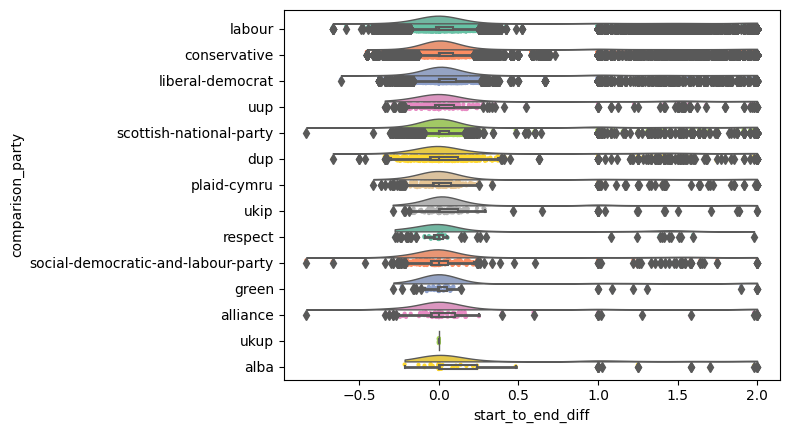

In [17]:
# changes on everything - for distribution by party changes
ptp.RainCloud(y="start_to_end_diff", x="comparison_party", data=df, orient="h")

# Party comparison differences

The following table shows policies where there is a new highlightable difference (0.4 vs 0.6 one way or the other), or a previous highlightable difference has gone away. 


In [18]:
df = jf

df = df.pivot_table(
    index=["policy_id", "person_id", "comparison_party"],
    columns=["is_target"],
    values=["pw_score_old", "simple_score_new"],
    aggfunc="first",
).reset_index()


def is_notable(series_a, series_b) -> pd.Series[bool]:
    return (series_a < 0.4) & (series_b > 0.6) | (series_a > 0.6) & (series_b < 0.4)


no_valid_policy = (df[("pw_score_old", 1)] == -1) | (df[("simple_score_new", 1)] == -1)
df = df.drop(df[no_valid_policy].index)


df["old_diff"] = df[("pw_score_old", 0)] - df[("pw_score_old", 1)]
df["old_notable"] = is_notable(df[("pw_score_old", 0)], df[("pw_score_old", 1)])
df["new_diff"] = df[("simple_score_new", 0)] - df[("simple_score_new", 1)]
df["new_notable"] = is_notable(df[("simple_score_new", 0)], df[("simple_score_new", 1)])
df["diff_diff"] = df["old_diff"] - df["new_diff"]
df["notable_diff"] = np.select(
    [
        (df["old_notable"] == True) & (df["new_notable"] == False),
        (df["old_notable"] == False) & (df["new_notable"] == True),
    ],
    ["was_notable", "now_notable"],
    default="no_change",
)

df["policy_name"] = df["policy_id"].map(active_ids)
df["person_name"] = df["person_id"].astype(str).map(person_name_map)
df["is_current_mp"] = df["person_id"].isin(current_mp_ids)
df["is_active_policy"] = df["policy_id"].isin(active_ids.keys())

df = df[df["is_current_mp"] == 1]
df = df[df["is_active_policy"] == 1]

ndf = df[df["notable_diff"] != "no_change"]

pt = ndf.pivot_table(
    index="policy_name",
    columns="notable_diff",
    values="person_id",
    aggfunc="count",
    fill_value=0,
)
pt.columns = [x[1] for x in pt.columns]


pt["total"] = pt["now_notable"] + pt["was_notable"]
pt = pt.sort_values("total", ascending=False)
pt.head(20)

/tmp/ipykernel_1935/1220048492.py:43: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pt = ndf.pivot_table(


,now_notable,was_notable,total
policy_name,,,
Removing Hereditary Peers from the House of Lords (1079),30,7,37
An Elected House of Lords (837),31,5,36
Same Sex Marriage (6686),19,0,19
Use of UK Military Forces In Combat Abroad (6688),14,0,14
Tax Avoidance (6690),6,0,6
Gambling Regulation (810),5,0,5
fewer MPs in the House of Commons (1136),5,0,5
Transparancy of Parliament (996),4,0,4
Pub Leases (6705),0,4,4


In [19]:
pt.sum()

now_notable    163
was_notable     18
total          181
dtype: int64

## And the same for specific people

Generally not many changes here - which makes sense because the threshold is high. 

Jeffrey M. Donaldson is an outlier here because we're calculating a UUP comparison, but in practice will not use it. 

In [20]:
pt = ndf.pivot_table(
    index="person_name",
    columns="notable_diff",
    values="person_id",
    aggfunc="count",
    fill_value=0,
)
pt.columns = [x[1] for x in pt.columns]

pt["total"] = pt["now_notable"] + pt["was_notable"]
pt = pt.sort_values("total", ascending=False)
pt.head(10)

/tmp/ipykernel_1935/480903506.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pt = ndf.pivot_table(


,now_notable,was_notable,total
person_name,,,
Jeffrey M. Donaldson (10172),10,1,11
Eleanor Laing (10348),4,0,4
George Galloway (10218),4,0,4
Lindsay Hoyle (10295),3,0,3
Jason McCartney (24887),3,0,3
George Eustice (24933),3,0,3
Ian Paisley Jnr (13852),2,1,3
Robin Walker (24862),2,0,2
Andrew Percy (24832),2,0,2


## Example of what this means on an individual level

Looking at Jeremy Corbyn's changes - the notability change is mostly driven by changes in the overall Labour party score - in one case moving a lot on transparent Parliament, and in the other case a very small change now crosses the 0.4/0.6 threshold for highlighting. 

In [21]:
ndf[ndf["person_id"] == 10133]

policy_id person_id comparison_party pw_score_old            \
is_target                                                 0         1   
12023           996     10133           labour     0.554354  0.179487   
51232          6688     10133           labour     0.409741  0.971204   

          simple_score_new        old_diff old_notable  new_diff new_notable  \
is_target                0     1                                               
12023             0.840000  0.16  0.374867       False  0.680000        True   
51232             0.363565  1.00 -0.561463       False -0.636435        True   

          diff_diff notable_diff  \
is_target                          
12023     -0.305133  now_notable   
51232      0.074972  now_notable   

                                                 policy_name  \
is_target                                                      
12023                       Transparancy of Parliament (996)   
51232      Use of UK Military Forces In Combat Abroad (6688)   

                     person_name is_current_mp is_active_policy  
is_target                                                        
12023      Jeremy Corbyn (10133)          True             True  
51232      Jeremy Corbyn (10133)          True             True